# 04. Transfer Learning with TensorFlow Part 1: Feature Extraction

In [1]:
!nvidia-smi

Mon Dec 12 04:58:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2022-12-12 04:58:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.4MB/s    in 8.1s    

2022-12-12 04:58:53 (19.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os

for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing Images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


In [14]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback

## Create models using TensorFlow Hub
1. EfficiantNet - Vector Model Link - https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
2. Resnet V2 50 - Vector Model Link - https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

In [6]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [12]:
def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False,
                                            name='feature_extraction_layer',
                                            input_shape=IMAGE_SHAPE+(3,))
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

In [15]:
# Create Model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving Tensorboard log files to: tensorflow_hub/resnet50V2/20221212-050658
Epoch 1/5
24/24 [==============================] - 28s 746ms/step - loss: 1.8332 - accuracy: 0.3840 - val_loss: 1.1514 - val_accuracy: 0.6416
Epoch 2/5
24/24 [==============================] - 16s 670ms/step - loss: 0.9070 - accuracy: 0.7200 - val_loss: 0.8479 - val_accuracy: 0.7172
Epoch 3/5
24/24 [==============================] - 16s 670ms/step - loss: 0.6281 - accuracy: 0.8227 - val_loss: 0.7479 - val_accuracy: 0.7536
Epoch 4/5
24/24 [==============================] - 16s 673ms/step - loss: 0.4926 - accuracy: 0.8733 - val_loss: 0.7149 - val_accuracy: 0.7632
Epoch 5/5
24/24 [==============================] - 16s 677ms/step - loss: 0.3903 - accuracy: 0.9133 - val_loss: 0.6690 - val_accuracy: 0.7832


In [17]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Val_Loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='Training_Accuracy')
  plt.plot(epochs, val_accuracy, label='Val_Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

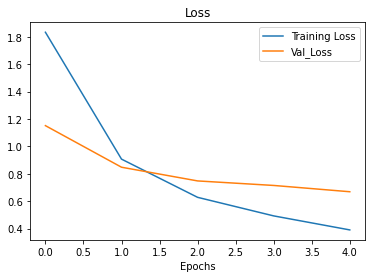

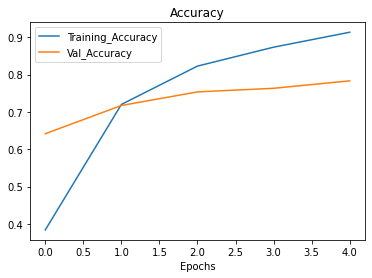

In [18]:
plot_loss_curves(resnet_history)

In [19]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [21]:
# Create the model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile the Model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit the Model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetB0")])

Saving Tensorboard log files to: tensorflow_hub/efficientnetB0/20221212-052155
Epoch 1/5
24/24 [==============================] - 25s 701ms/step - loss: 1.8483 - accuracy: 0.4387 - val_loss: 1.2807 - val_accuracy: 0.7440
Epoch 2/5
24/24 [==============================] - 15s 653ms/step - loss: 1.0428 - accuracy: 0.7800 - val_loss: 0.8601 - val_accuracy: 0.8280
Epoch 3/5
24/24 [==============================] - 15s 653ms/step - loss: 0.7435 - accuracy: 0.8453 - val_loss: 0.6928 - val_accuracy: 0.8436
Epoch 4/5
24/24 [==============================] - 15s 655ms/step - loss: 0.6021 - accuracy: 0.8667 - val_loss: 0.6100 - val_accuracy: 0.8540
Epoch 5/5
24/24 [==============================] - 15s 648ms/step - loss: 0.5074 - accuracy: 0.8987 - val_loss: 0.5581 - val_accuracy: 0.8616


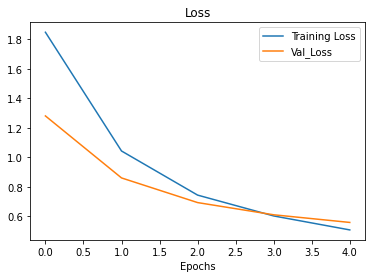

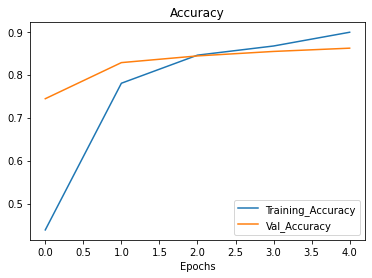

In [22]:
plot_loss_curves(efficientnet_history)

In [23]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________
